#구글 드라이브 마운트하여 구글 드라이브 사용

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


In [ ]:
pip install --upgrade efficientnet-pytorch

  Preparing metadata (setup.py) ... done
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16428 sha256=97853a79be49357b0e4f0b260d98e7783f773fef403bf570ab51cf71eaa7cfbe
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
Successfully built efficientnet-pytorch


#데이터 전처리

In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn # 인공 신경망 모델들 모아놓은 모듈
import torch.nn.functional as F #그중 자주 쓰이는것들을 F로
from torchvision import transforms, datasets
import cv2
import pandas as pd
import os
from glob import glob
import torchvision.models as models
import sys
import librosa, librosa.display
#from pytorchtools import EarlyStopping
from torch.utils.data import random_split, DataLoader
from torchvision.datasets import ImageFolder
from sklearn.model_selection import train_test_split


if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')
#DEVICE = torch.device('cpu')
print('Using Pytorch version : ',torch.__version__,' Device : ',DEVICE)

#3. 하이퍼 파라미터
BATCH_SIZE =  16 #한 배치당 16개 이미지데이터
EPOCHS = 20 # 전체 데이터 셋을 20번 반복

Using Pytorch version :  2.1.0+cu121  Device :  cuda


In [ ]:
train_data_dir= '/content/drive/MyDrive/느티나무 질병 데이터셋/train2' #클래스 불균형 해소시킨 데이터셋 새로 만들어서 train에 이용함
# Create the ImageFolder dataset
transform = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=(-25, 25)),
    #transforms.ColorJitter(brightness=0.6, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])
dataset = ImageFolder(root=train_data_dir, transform=transform)

#모델

In [ ]:
# 일단 이거로 해보기(freeze를 안 하고, 전체적으로 다 fine tuning함)
# freeze를 하면 기존모델(efficientnet)의 pretrained 부분을 그대로 가져오는 거
# freeze 안 하고 전체적으로 fine tuning해도 feature extract부분이 우리 task에 맞게 조정되고, 마지막 layer도 우리 task에 맞게 조정됨
import torch.nn as nn
import torch
from efficientnet_pytorch import EfficientNet

class ChannelAttentionModule(nn.Module):
    def __init__(self, channel, ratio=16):
        super(ChannelAttentionModule, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)

        self.shared_MLP = nn.Sequential(
            nn.Conv2d(channel, channel // ratio, 1, bias=False),
            nn.ReLU(),
            nn.Conv2d(channel // ratio, channel, 1, bias=False)
        )
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avgout = self.shared_MLP(self.avg_pool(x))
        maxout = self.shared_MLP(self.max_pool(x))
        return self.sigmoid(avgout + maxout)

class SpatialAttentionModule(nn.Module):
    def __init__(self):
        super(SpatialAttentionModule, self).__init__()
        self.conv2d = nn.Conv2d(in_channels=2, out_channels=1, kernel_size=7, stride=1, padding=3)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avgout = torch.mean(x, dim=1, keepdim=True)
        maxout, _ = torch.max(x, dim=1, keepdim=True)
        out = torch.cat([avgout, maxout], dim=1)
        out = self.sigmoid(self.conv2d(out))
        return out

class CBAM(nn.Module):
    def __init__(self, channel):
        super(CBAM, self).__init__()
        self.channel_attention = ChannelAttentionModule(channel)
        self.spatial_attention = SpatialAttentionModule()

    def forward(self, x):
        out = self.channel_attention(x) * x
        out = self.spatial_attention(out) * out
        return out

class ResBlock_CBAM(nn.Module):
    def __init__(self,in_places, places, stride=1,downsampling=False, expansion = 4):
        super(ResBlock_CBAM,self).__init__()
        self.expansion = expansion
        self.downsampling = downsampling

        self.bottleneck = nn.Sequential(
            nn.Conv2d(in_channels=in_places,out_channels=places,kernel_size=1,stride=1, bias=False),
            nn.BatchNorm2d(places),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=places, out_channels=places, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(places),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=places, out_channels=places*self.expansion, kernel_size=1, stride=1, bias=False),
            nn.BatchNorm2d(places*self.expansion),
        )
        self.cbam = CBAM(channel=places*self.expansion)

        if self.downsampling:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels=in_places, out_channels=places*self.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(places*self.expansion)
            )
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        residual = x
        out = self.bottleneck(x)
        out = self.cbam(out)
        if self.downsampling:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)
        return out

class CBAM_efficientnet(nn.Module):
    """
    Simple transfer learning model that takes an imagenet pretrained model with
    a fc layer as base model and retrains a new fc layer for num_out_classes
    """
    def __init__(self, model_name='efficientnet-b0', num_classes=2):
        super(CBAM_efficientnet, self).__init__()
        self.base = EfficientNet.from_pretrained(model_name)
        # net = EfficientNet.from_name(model_name)
        in_features = self.base._fc.in_features
        self.cbam = CBAM(channel=in_features)
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.clf = nn.Sequential(nn.BatchNorm1d(in_features),
                                 nn.Linear(in_features=in_features, out_features=num_classes, bias=True))

    def forward(self, x):
        x = self.base.extract_features(x)
        x = self.cbam(x)
        x = self.avg_pool(x)
        x = x.view(x.size(0), -1)  # flatten to (bs, 2048)
        x = self.clf(x)

        return x

    def extract_features(self, x):
        x = self.base.extract_features(x)
        x = self.cbam(x)

        return x

# 모델 생성
model = CBAM_efficientnet('efficientnet-b7', num_classes=2)
model.to(device)

Loaded pretrained weights for efficientnet-b7


In [ ]:
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torch.optim.lr_scheduler import MultiStepLR
from torch.optim.lr_scheduler import LambdaLR

lr = 0.0001

#클래스 불균형 해소
num_ins = [365, 378]
weights = [1 - (x/sum(num_ins)) for x in num_ins]
class_weights = torch.FloatTensor(weights).to(DEVICE)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.0001, weight_decay=1e-5)
scheduler = StepLR(optimizer, step_size=20, gamma=0.5)


In [ ]:
#8. 학습
def train(model,train_loader,optimizer, log_interval):
    model.train()
    correct = 0
    train_loss = 0
    for batch_idx,(image,label) in enumerate(train_loader):
        image = image.to(DEVICE)
        label = label.to(DEVICE)
        #데이터들 장비에 할당
        optimizer.zero_grad() # device 에 저장된 gradient 제거
        output = model(image) # model로 output을 계산
        loss = criterion(output, label) #loss 계산
        train_loss += loss.item()
        prediction = output.max(1,keepdim=True)[1] # 가장 확률이 높은 class 1개를 가져온다.그리고 인덱스만
        correct += prediction.eq(label.view_as(prediction)).sum().item()# 아웃풋이 배치 사이즈 32개라서.
        loss.backward() # loss 값을 이용해 gradient를 계산
        optimizer.step() # Gradient 값을 이용해 파라미터 업데이트.
    train_loss/=len(train_loader.dataset)
    train_accuracy = 100. * correct / len(train_loader.dataset)
    return train_loss,train_accuracy

In [ ]:
#9. 학습 진행하며, validation 데이터로 모델 성능확인
def evaluate(model,valid_loader):
    model.eval()
    misclassified_images = []
    valid_loss = 0
    correct = 0
    #no_grad : 그래디언트 값 계산 막기.
    with torch.no_grad():
        for image, label in valid_loader:
            image = image.to(DEVICE)
            label = label.to(DEVICE)
            output = model(image)
            valid_loss += criterion(output, label).item()
            prediction = output.max(1,keepdim=True)[1] # 가장 확률이 높은 class 1개를 가져온다.그리고 인덱스만
            correct += prediction.eq(label.view_as(prediction)).sum().item()# 아웃풋이 배치 사이즈 32개라서.
                        # Check for misclassified images
            for i in range(label.size(0)):
                if prediction[i] != label[i]:
                    misclassified_images.append((image[i], prediction[i], label[i]))

            #true.false값을 sum해줌. item
        valid_loss /= len(valid_loader.dataset)
        valid_accuracy = 100. * correct / len(valid_loader.dataset)
        return valid_loss, valid_accuracy, misclassified_images

In [ ]:
import torch, gc
gc.collect()
torch.cuda.empty_cache()

In [ ]:
!pip install wandb

In [ ]:
!wandb login # 유진 : 6080be9f8ad8214dd6df2c097cb6657f599101c3
#예린이꺼 : 2760afae3cddc39355fd83d56a601147e18e1acf

wandb: Currently logged in as: iuapink0522. Use `wandb login --relogin` to force relogin


In [ ]:
!wandb login --relogin

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
import wandb
wandb.init(project='Plant2')

# 실행 이름 설정
wandb.run.name = 'EfficientNet-b7_pretrainedO_DataAug_불균형해소o'
wandb.run.save()

wandb: Currently logged in as: iuapink0522. Use `wandb login --relogin` to force relogin


wandb: WARNING Calling wandb.run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


True

In [ ]:
args = {
    "learning_rate": lr,
    "epochs": EPOCHS,
    "batch_size": BATCH_SIZE
}
wandb.config.update(args)

In [ ]:
import os
import numpy as np
from sklearn.model_selection import KFold
from copy import deepcopy
# Define the number of folds
num_folds = 5  # You can change this number as needed

# Initialize lists to store results for each fold
all_train_losses = []
all_train_accuracies = []
all_valid_losses = []
all_valid_accuracies = []

best_acc = 0
best_f1 = 0
best_acc_model = None
best_f1_model = None

# Create a KFold object to split your data
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

for fold, (train_indices, valid_indices) in enumerate(kf.split(dataset)):
    train_data = torch.utils.data.Subset(dataset, train_indices)
    valid_data = torch.utils.data.Subset(dataset, valid_indices)

    train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
    validation_loader = DataLoader(valid_data, batch_size=BATCH_SIZE)

    train_losses = []
    train_accuracies = []
    valid_losses = []
    valid_accuracies = []

    for Epoch in range(1, EPOCHS+1):
        train_loss, train_accuracy = train(model, train_loader, optimizer, log_interval=31)
        valid_loss, valid_accuracy, _ = evaluate(model, validation_loader)
        wandb.log({"Training loss": train_loss, "Train Acc": train_accuracy, "Val loss": valid_loss, "Val Acc": valid_accuracy})

        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        valid_losses.append(valid_loss)
        valid_accuracies.append(valid_accuracy)

        scheduler.step()

        print("\n[Fold {}][EPOCH:{}]\t Train Loss:{:.4f}\t Train Acc:{:.2f} %  | \tValid Loss:{:.4f} \tValid Acc: {:.2f} %\n".format(fold, Epoch, train_loss, train_accuracy, valid_loss, valid_accuracy))

    all_train_losses.append(train_losses)
    all_train_accuracies.append(train_accuracies)
    all_valid_losses.append(valid_losses)
    all_valid_accuracies.append(valid_accuracies)



/usr/local/lib/python3.10/dist-packages/PIL/Image.py:3167: DecompressionBombWarning: Image size (127401984 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:3167: DecompressionBombWarning: Image size (113246208 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(



[Fold 0][EPOCH:1]	 Train Loss:0.0330	 Train Acc:79.12 %  | 	Valid Loss:0.0306 	Valid Acc: 73.15 %



/usr/local/lib/python3.10/dist-packages/PIL/Image.py:3167: DecompressionBombWarning: Image size (102411238 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:3167: DecompressionBombWarning: Image size (110258449 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(



[Fold 0][EPOCH:2]	 Train Loss:0.0103	 Train Acc:95.96 %  | 	Valid Loss:0.0123 	Valid Acc: 92.62 %



/usr/local/lib/python3.10/dist-packages/PIL/Image.py:3167: DecompressionBombWarning: Image size (106213668 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(



[Fold 0][EPOCH:3]	 Train Loss:0.0064	 Train Acc:97.64 %  | 	Valid Loss:0.0047 	Valid Acc: 97.32 %


[Fold 0][EPOCH:4]	 Train Loss:0.0066	 Train Acc:97.98 %  | 	Valid Loss:0.0038 	Valid Acc: 97.99 %


[Fold 0][EPOCH:5]	 Train Loss:0.0026	 Train Acc:98.82 %  | 	Valid Loss:0.0030 	Valid Acc: 97.99 %


[Fold 0][EPOCH:6]	 Train Loss:0.0014	 Train Acc:99.49 %  | 	Valid Loss:0.0019 	Valid Acc: 99.33 %



/usr/local/lib/python3.10/dist-packages/PIL/Image.py:3167: DecompressionBombWarning: Image size (108380318 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(



[Fold 0][EPOCH:7]	 Train Loss:0.0018	 Train Acc:99.16 %  | 	Valid Loss:0.0035 	Valid Acc: 96.64 %



/usr/local/lib/python3.10/dist-packages/PIL/Image.py:3167: DecompressionBombWarning: Image size (102064323 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(



[Fold 0][EPOCH:8]	 Train Loss:0.0034	 Train Acc:98.99 %  | 	Valid Loss:0.0027 	Valid Acc: 97.99 %



/usr/local/lib/python3.10/dist-packages/PIL/Image.py:3167: DecompressionBombWarning: Image size (107001423 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(



[Fold 0][EPOCH:9]	 Train Loss:0.0034	 Train Acc:98.65 %  | 	Valid Loss:0.0036 	Valid Acc: 98.66 %



/usr/local/lib/python3.10/dist-packages/PIL/Image.py:3167: DecompressionBombWarning: Image size (112874713 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(



[Fold 0][EPOCH:10]	 Train Loss:0.0066	 Train Acc:98.99 %  | 	Valid Loss:0.0028 	Valid Acc: 98.66 %


[Fold 0][EPOCH:11]	 Train Loss:0.0037	 Train Acc:98.32 %  | 	Valid Loss:0.0032 	Valid Acc: 97.99 %


[Fold 0][EPOCH:12]	 Train Loss:0.0014	 Train Acc:99.66 %  | 	Valid Loss:0.0031 	Valid Acc: 97.99 %


[Fold 0][EPOCH:13]	 Train Loss:0.0053	 Train Acc:99.33 %  | 	Valid Loss:0.0035 	Valid Acc: 97.99 %



/usr/local/lib/python3.10/dist-packages/PIL/Image.py:3167: DecompressionBombWarning: Image size (109118937 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(



[Fold 0][EPOCH:14]	 Train Loss:0.0044	 Train Acc:98.32 %  | 	Valid Loss:0.0037 	Valid Acc: 97.99 %


[Fold 0][EPOCH:15]	 Train Loss:0.0095	 Train Acc:98.32 %  | 	Valid Loss:0.0015 	Valid Acc: 99.33 %


[Fold 0][EPOCH:16]	 Train Loss:0.0043	 Train Acc:99.33 %  | 	Valid Loss:0.0024 	Valid Acc: 98.66 %



/usr/local/lib/python3.10/dist-packages/PIL/Image.py:3167: DecompressionBombWarning: Image size (103053972 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(



[Fold 0][EPOCH:17]	 Train Loss:0.0029	 Train Acc:98.65 %  | 	Valid Loss:0.0034 	Valid Acc: 97.99 %



/usr/local/lib/python3.10/dist-packages/PIL/Image.py:3167: DecompressionBombWarning: Image size (110872807 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(



[Fold 0][EPOCH:18]	 Train Loss:0.0038	 Train Acc:99.33 %  | 	Valid Loss:0.0032 	Valid Acc: 96.64 %



/usr/local/lib/python3.10/dist-packages/PIL/Image.py:3167: DecompressionBombWarning: Image size (112432681 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(



[Fold 0][EPOCH:19]	 Train Loss:0.0027	 Train Acc:98.65 %  | 	Valid Loss:0.0045 	Valid Acc: 96.64 %


[Fold 0][EPOCH:20]	 Train Loss:0.0027	 Train Acc:98.32 %  | 	Valid Loss:0.0019 	Valid Acc: 99.33 %



/usr/local/lib/python3.10/dist-packages/PIL/Image.py:3167: DecompressionBombWarning: Image size (102895605 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(



[Fold 1][EPOCH:1]	 Train Loss:0.0027	 Train Acc:98.15 %  | 	Valid Loss:0.0001 	Valid Acc: 100.00 %



/usr/local/lib/python3.10/dist-packages/PIL/Image.py:3167: DecompressionBombWarning: Image size (104562508 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(



[Fold 1][EPOCH:2]	 Train Loss:0.0014	 Train Acc:99.49 %  | 	Valid Loss:0.0001 	Valid Acc: 100.00 %



/usr/local/lib/python3.10/dist-packages/PIL/Image.py:3167: DecompressionBombWarning: Image size (106214400 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:3167: DecompressionBombWarning: Image size (102797092 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(



[Fold 1][EPOCH:3]	 Train Loss:0.0010	 Train Acc:99.83 %  | 	Valid Loss:0.0001 	Valid Acc: 100.00 %



/usr/local/lib/python3.10/dist-packages/PIL/Image.py:3167: DecompressionBombWarning: Image size (104018795 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(



[Fold 1][EPOCH:4]	 Train Loss:0.0007	 Train Acc:99.83 %  | 	Valid Loss:0.0001 	Valid Acc: 100.00 %



/usr/local/lib/python3.10/dist-packages/PIL/Image.py:3167: DecompressionBombWarning: Image size (106100352 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:3167: DecompressionBombWarning: Image size (102062500 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(



[Fold 1][EPOCH:5]	 Train Loss:0.0009	 Train Acc:99.49 %  | 	Valid Loss:0.0001 	Valid Acc: 100.00 %



/usr/local/lib/python3.10/dist-packages/PIL/Image.py:3167: DecompressionBombWarning: Image size (103672692 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(



[Fold 1][EPOCH:6]	 Train Loss:0.0049	 Train Acc:99.83 %  | 	Valid Loss:0.0001 	Valid Acc: 100.00 %



/usr/local/lib/python3.10/dist-packages/PIL/Image.py:3167: DecompressionBombWarning: Image size (105334720 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(



[Fold 1][EPOCH:7]	 Train Loss:0.0006	 Train Acc:99.83 %  | 	Valid Loss:0.0003 	Valid Acc: 100.00 %



/usr/local/lib/python3.10/dist-packages/PIL/Image.py:3167: DecompressionBombWarning: Image size (106808526 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:3167: DecompressionBombWarning: Image size (105786936 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(



[Fold 1][EPOCH:8]	 Train Loss:0.0030	 Train Acc:99.49 %  | 	Valid Loss:0.0002 	Valid Acc: 100.00 %



/usr/local/lib/python3.10/dist-packages/PIL/Image.py:3167: DecompressionBombWarning: Image size (102194388 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(



[Fold 1][EPOCH:9]	 Train Loss:0.0043	 Train Acc:99.33 %  | 	Valid Loss:0.0003 	Valid Acc: 100.00 %



/usr/local/lib/python3.10/dist-packages/PIL/Image.py:3167: DecompressionBombWarning: Image size (102990727 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:3167: DecompressionBombWarning: Image size (106883208 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(



[Fold 1][EPOCH:10]	 Train Loss:0.0019	 Train Acc:99.33 %  | 	Valid Loss:0.0003 	Valid Acc: 100.00 %



/usr/local/lib/python3.10/dist-packages/PIL/Image.py:3167: DecompressionBombWarning: Image size (104510370 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:3167: DecompressionBombWarning: Image size (102077955 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(



[Fold 1][EPOCH:11]	 Train Loss:0.0011	 Train Acc:99.66 %  | 	Valid Loss:0.0002 	Valid Acc: 100.00 %



/usr/local/lib/python3.10/dist-packages/PIL/Image.py:3167: DecompressionBombWarning: Image size (106774335 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:3167: DecompressionBombWarning: Image size (106058274 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(



[Fold 1][EPOCH:12]	 Train Loss:0.0003	 Train Acc:100.00 %  | 	Valid Loss:0.0001 	Valid Acc: 100.00 %


[Fold 1][EPOCH:13]	 Train Loss:0.0030	 Train Acc:99.83 %  | 	Valid Loss:0.0001 	Valid Acc: 100.00 %


[Fold 1][EPOCH:14]	 Train Loss:0.0044	 Train Acc:99.33 %  | 	Valid Loss:0.0005 	Valid Acc: 99.33 %


[Fold 1][EPOCH:15]	 Train Loss:0.0016	 Train Acc:98.99 %  | 	Valid Loss:0.0005 	Valid Acc: 100.00 %



/usr/local/lib/python3.10/dist-packages/PIL/Image.py:3167: DecompressionBombWarning: Image size (108801088 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(



[Fold 1][EPOCH:16]	 Train Loss:0.0005	 Train Acc:100.00 %  | 	Valid Loss:0.0001 	Valid Acc: 100.00 %



/usr/local/lib/python3.10/dist-packages/PIL/Image.py:3167: DecompressionBombWarning: Image size (107925259 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(



[Fold 1][EPOCH:17]	 Train Loss:0.0011	 Train Acc:99.83 %  | 	Valid Loss:0.0001 	Valid Acc: 100.00 %



/usr/local/lib/python3.10/dist-packages/PIL/Image.py:3167: DecompressionBombWarning: Image size (105518400 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(



[Fold 1][EPOCH:18]	 Train Loss:0.0007	 Train Acc:99.83 %  | 	Valid Loss:0.0001 	Valid Acc: 100.00 %


[Fold 1][EPOCH:19]	 Train Loss:0.0024	 Train Acc:99.66 %  | 	Valid Loss:0.0001 	Valid Acc: 100.00 %



/usr/local/lib/python3.10/dist-packages/PIL/Image.py:3167: DecompressionBombWarning: Image size (106725774 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(



[Fold 1][EPOCH:20]	 Train Loss:0.0004	 Train Acc:100.00 %  | 	Valid Loss:0.0001 	Valid Acc: 100.00 %



/usr/local/lib/python3.10/dist-packages/PIL/Image.py:3167: DecompressionBombWarning: Image size (103326189 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(



[Fold 2][EPOCH:1]	 Train Loss:0.0062	 Train Acc:99.66 %  | 	Valid Loss:0.0000 	Valid Acc: 100.00 %



/usr/local/lib/python3.10/dist-packages/PIL/Image.py:3167: DecompressionBombWarning: Image size (102565904 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:3167: DecompressionBombWarning: Image size (109567465 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(



[Fold 2][EPOCH:2]	 Train Loss:0.0017	 Train Acc:99.66 %  | 	Valid Loss:0.0001 	Valid Acc: 100.00 %


[Fold 2][EPOCH:3]	 Train Loss:0.0021	 Train Acc:99.83 %  | 	Valid Loss:0.0001 	Valid Acc: 100.00 %



/usr/local/lib/python3.10/dist-packages/PIL/Image.py:3167: DecompressionBombWarning: Image size (110373197 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(



[Fold 2][EPOCH:4]	 Train Loss:0.0014	 Train Acc:99.83 %  | 	Valid Loss:0.0000 	Valid Acc: 100.00 %



/usr/local/lib/python3.10/dist-packages/PIL/Image.py:3167: DecompressionBombWarning: Image size (103727940 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(



[Fold 2][EPOCH:5]	 Train Loss:0.0003	 Train Acc:100.00 %  | 	Valid Loss:0.0000 	Valid Acc: 100.00 %



/usr/local/lib/python3.10/dist-packages/PIL/Image.py:3167: DecompressionBombWarning: Image size (104623134 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(



[Fold 2][EPOCH:6]	 Train Loss:0.0003	 Train Acc:100.00 %  | 	Valid Loss:0.0000 	Valid Acc: 100.00 %



/usr/local/lib/python3.10/dist-packages/PIL/Image.py:3167: DecompressionBombWarning: Image size (105385176 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(



[Fold 2][EPOCH:7]	 Train Loss:0.0021	 Train Acc:99.49 %  | 	Valid Loss:0.0000 	Valid Acc: 100.00 %



/usr/local/lib/python3.10/dist-packages/PIL/Image.py:3167: DecompressionBombWarning: Image size (106939796 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(



[Fold 2][EPOCH:8]	 Train Loss:0.0017	 Train Acc:99.83 %  | 	Valid Loss:0.0000 	Valid Acc: 100.00 %



/usr/local/lib/python3.10/dist-packages/PIL/Image.py:3167: DecompressionBombWarning: Image size (103435489 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:3167: DecompressionBombWarning: Image size (104228074 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:3167: DecompressionBombWarning: Image size (105362221 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(



[Fold 2][EPOCH:9]	 Train Loss:0.0020	 Train Acc:99.83 %  | 	Valid Loss:0.0000 	Valid Acc: 100.00 %



/usr/local/lib/python3.10/dist-packages/PIL/Image.py:3167: DecompressionBombWarning: Image size (104284980 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(



[Fold 2][EPOCH:10]	 Train Loss:0.0002	 Train Acc:100.00 %  | 	Valid Loss:0.0000 	Valid Acc: 100.00 %


[Fold 2][EPOCH:11]	 Train Loss:0.0003	 Train Acc:100.00 %  | 	Valid Loss:0.0000 	Valid Acc: 100.00 %



/usr/local/lib/python3.10/dist-packages/PIL/Image.py:3167: DecompressionBombWarning: Image size (109130364 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:3167: DecompressionBombWarning: Image size (103635538 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(



[Fold 2][EPOCH:12]	 Train Loss:0.0003	 Train Acc:100.00 %  | 	Valid Loss:0.0000 	Valid Acc: 100.00 %



/usr/local/lib/python3.10/dist-packages/PIL/Image.py:3167: DecompressionBombWarning: Image size (102289264 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(



[Fold 2][EPOCH:13]	 Train Loss:0.0002	 Train Acc:100.00 %  | 	Valid Loss:0.0000 	Valid Acc: 100.00 %



/usr/local/lib/python3.10/dist-packages/PIL/Image.py:3167: DecompressionBombWarning: Image size (107654484 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:3167: DecompressionBombWarning: Image size (102220443 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(



[Fold 2][EPOCH:14]	 Train Loss:0.0012	 Train Acc:99.83 %  | 	Valid Loss:0.0000 	Valid Acc: 100.00 %



/usr/local/lib/python3.10/dist-packages/PIL/Image.py:3167: DecompressionBombWarning: Image size (107655729 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:3167: DecompressionBombWarning: Image size (106570740 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(



[Fold 2][EPOCH:15]	 Train Loss:0.0005	 Train Acc:99.66 %  | 	Valid Loss:0.0000 	Valid Acc: 100.00 %



/usr/local/lib/python3.10/dist-packages/PIL/Image.py:3167: DecompressionBombWarning: Image size (109968738 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(



[Fold 2][EPOCH:16]	 Train Loss:0.0023	 Train Acc:99.83 %  | 	Valid Loss:0.0000 	Valid Acc: 100.00 %



/usr/local/lib/python3.10/dist-packages/PIL/Image.py:3167: DecompressionBombWarning: Image size (102171300 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:3167: DecompressionBombWarning: Image size (107784180 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(



[Fold 2][EPOCH:17]	 Train Loss:0.0018	 Train Acc:99.49 %  | 	Valid Loss:0.0000 	Valid Acc: 100.00 %



/usr/local/lib/python3.10/dist-packages/PIL/Image.py:3167: DecompressionBombWarning: Image size (104714275 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(



[Fold 2][EPOCH:18]	 Train Loss:0.0021	 Train Acc:99.66 %  | 	Valid Loss:0.0000 	Valid Acc: 100.00 %



/usr/local/lib/python3.10/dist-packages/PIL/Image.py:3167: DecompressionBombWarning: Image size (102211773 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:3167: DecompressionBombWarning: Image size (107266595 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(



[Fold 2][EPOCH:19]	 Train Loss:0.0001	 Train Acc:100.00 %  | 	Valid Loss:0.0000 	Valid Acc: 100.00 %



/usr/local/lib/python3.10/dist-packages/PIL/Image.py:3167: DecompressionBombWarning: Image size (104358408 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:3167: DecompressionBombWarning: Image size (110032699 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:3167: DecompressionBombWarning: Image size (112170420 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(



[Fold 2][EPOCH:20]	 Train Loss:0.0001	 Train Acc:100.00 %  | 	Valid Loss:0.0000 	Valid Acc: 100.00 %



/usr/local/lib/python3.10/dist-packages/PIL/Image.py:3167: DecompressionBombWarning: Image size (112522320 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:3167: DecompressionBombWarning: Image size (111042120 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(



[Fold 3][EPOCH:1]	 Train Loss:0.0002	 Train Acc:100.00 %  | 	Valid Loss:0.0000 	Valid Acc: 100.00 %


[Fold 3][EPOCH:2]	 Train Loss:0.0003	 Train Acc:100.00 %  | 	Valid Loss:0.0000 	Valid Acc: 100.00 %



/usr/local/lib/python3.10/dist-packages/PIL/Image.py:3167: DecompressionBombWarning: Image size (103818888 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(



[Fold 3][EPOCH:3]	 Train Loss:0.0001	 Train Acc:100.00 %  | 	Valid Loss:0.0000 	Valid Acc: 100.00 %


[Fold 3][EPOCH:4]	 Train Loss:0.0034	 Train Acc:99.33 %  | 	Valid Loss:0.0000 	Valid Acc: 100.00 %



/usr/local/lib/python3.10/dist-packages/PIL/Image.py:3167: DecompressionBombWarning: Image size (102423062 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:3167: DecompressionBombWarning: Image size (103861160 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(



[Fold 3][EPOCH:5]	 Train Loss:0.0025	 Train Acc:99.83 %  | 	Valid Loss:0.0000 	Valid Acc: 100.00 %



/usr/local/lib/python3.10/dist-packages/PIL/Image.py:3167: DecompressionBombWarning: Image size (102596724 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:3167: DecompressionBombWarning: Image size (108859564 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(



[Fold 3][EPOCH:6]	 Train Loss:0.0019	 Train Acc:99.66 %  | 	Valid Loss:0.0000 	Valid Acc: 100.00 %


[Fold 3][EPOCH:7]	 Train Loss:0.0002	 Train Acc:100.00 %  | 	Valid Loss:0.0000 	Valid Acc: 100.00 %


[Fold 3][EPOCH:8]	 Train Loss:0.0001	 Train Acc:100.00 %  | 	Valid Loss:0.0000 	Valid Acc: 100.00 %



/usr/local/lib/python3.10/dist-packages/PIL/Image.py:3167: DecompressionBombWarning: Image size (104744640 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:3167: DecompressionBombWarning: Image size (102113865 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(



[Fold 3][EPOCH:9]	 Train Loss:0.0001	 Train Acc:100.00 %  | 	Valid Loss:0.0000 	Valid Acc: 100.00 %



/usr/local/lib/python3.10/dist-packages/PIL/Image.py:3167: DecompressionBombWarning: Image size (108431460 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(



[Fold 3][EPOCH:10]	 Train Loss:0.0002	 Train Acc:100.00 %  | 	Valid Loss:0.0000 	Valid Acc: 100.00 %



/usr/local/lib/python3.10/dist-packages/PIL/Image.py:3167: DecompressionBombWarning: Image size (107598364 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(



[Fold 3][EPOCH:11]	 Train Loss:0.0001	 Train Acc:100.00 %  | 	Valid Loss:0.0000 	Valid Acc: 100.00 %



/usr/local/lib/python3.10/dist-packages/PIL/Image.py:3167: DecompressionBombWarning: Image size (107018208 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(



[Fold 3][EPOCH:12]	 Train Loss:0.0016	 Train Acc:99.66 %  | 	Valid Loss:0.0000 	Valid Acc: 100.00 %



/usr/local/lib/python3.10/dist-packages/PIL/Image.py:3167: DecompressionBombWarning: Image size (104762130 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(



[Fold 3][EPOCH:13]	 Train Loss:0.0003	 Train Acc:100.00 %  | 	Valid Loss:0.0000 	Valid Acc: 100.00 %



/usr/local/lib/python3.10/dist-packages/PIL/Image.py:3167: DecompressionBombWarning: Image size (107949300 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(



[Fold 3][EPOCH:14]	 Train Loss:0.0001	 Train Acc:100.00 %  | 	Valid Loss:0.0000 	Valid Acc: 100.00 %



/usr/local/lib/python3.10/dist-packages/PIL/Image.py:3167: DecompressionBombWarning: Image size (107358674 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:3167: DecompressionBombWarning: Image size (103397688 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(



[Fold 3][EPOCH:15]	 Train Loss:0.0002	 Train Acc:100.00 %  | 	Valid Loss:0.0000 	Valid Acc: 100.00 %


[Fold 3][EPOCH:16]	 Train Loss:0.0003	 Train Acc:99.83 %  | 	Valid Loss:0.0000 	Valid Acc: 100.00 %



/usr/local/lib/python3.10/dist-packages/PIL/Image.py:3167: DecompressionBombWarning: Image size (104511168 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:3167: DecompressionBombWarning: Image size (104579293 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(



[Fold 3][EPOCH:17]	 Train Loss:0.0002	 Train Acc:100.00 %  | 	Valid Loss:0.0000 	Valid Acc: 100.00 %


[Fold 3][EPOCH:18]	 Train Loss:0.0001	 Train Acc:100.00 %  | 	Valid Loss:0.0000 	Valid Acc: 100.00 %


[Fold 3][EPOCH:19]	 Train Loss:0.0001	 Train Acc:100.00 %  | 	Valid Loss:0.0000 	Valid Acc: 100.00 %


[Fold 3][EPOCH:20]	 Train Loss:0.0001	 Train Acc:100.00 %  | 	Valid Loss:0.0000 	Valid Acc: 100.00 %


[Fold 4][EPOCH:1]	 Train Loss:0.0001	 Train Acc:100.00 %  | 	Valid Loss:0.0000 	Valid Acc: 100.00 %


[Fold 4][EPOCH:2]	 Train Loss:0.0003	 Train Acc:99.83 %  | 	Valid Loss:0.0000 	Valid Acc: 100.00 %



/usr/local/lib/python3.10/dist-packages/PIL/Image.py:3167: DecompressionBombWarning: Image size (106138650 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:3167: DecompressionBombWarning: Image size (106368990 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(



[Fold 4][EPOCH:3]	 Train Loss:0.0001	 Train Acc:100.00 %  | 	Valid Loss:0.0000 	Valid Acc: 100.00 %



/usr/local/lib/python3.10/dist-packages/PIL/Image.py:3167: DecompressionBombWarning: Image size (109476194 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(



[Fold 4][EPOCH:4]	 Train Loss:0.0001	 Train Acc:100.00 %  | 	Valid Loss:0.0000 	Valid Acc: 100.00 %



/usr/local/lib/python3.10/dist-packages/PIL/Image.py:3167: DecompressionBombWarning: Image size (103277452 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(



[Fold 4][EPOCH:5]	 Train Loss:0.0001	 Train Acc:100.00 %  | 	Valid Loss:0.0000 	Valid Acc: 100.00 %


[Fold 4][EPOCH:6]	 Train Loss:0.0001	 Train Acc:100.00 %  | 	Valid Loss:0.0000 	Valid Acc: 100.00 %



/usr/local/lib/python3.10/dist-packages/PIL/Image.py:3167: DecompressionBombWarning: Image size (107170877 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(



[Fold 4][EPOCH:7]	 Train Loss:0.0001	 Train Acc:100.00 %  | 	Valid Loss:0.0000 	Valid Acc: 100.00 %



/usr/local/lib/python3.10/dist-packages/PIL/Image.py:3167: DecompressionBombWarning: Image size (104239308 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:3167: DecompressionBombWarning: Image size (106827987 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(



[Fold 4][EPOCH:8]	 Train Loss:0.0001	 Train Acc:100.00 %  | 	Valid Loss:0.0000 	Valid Acc: 100.00 %


[Fold 4][EPOCH:9]	 Train Loss:0.0001	 Train Acc:100.00 %  | 	Valid Loss:0.0000 	Valid Acc: 100.00 %



/usr/local/lib/python3.10/dist-packages/PIL/Image.py:3167: DecompressionBombWarning: Image size (104839438 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(



[Fold 4][EPOCH:10]	 Train Loss:0.0025	 Train Acc:99.66 %  | 	Valid Loss:0.0000 	Valid Acc: 100.00 %



/usr/local/lib/python3.10/dist-packages/PIL/Image.py:3167: DecompressionBombWarning: Image size (102996702 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(



[Fold 4][EPOCH:11]	 Train Loss:0.0001	 Train Acc:100.00 %  | 	Valid Loss:0.0000 	Valid Acc: 100.00 %


[Fold 4][EPOCH:12]	 Train Loss:0.0025	 Train Acc:99.83 %  | 	Valid Loss:0.0000 	Valid Acc: 100.00 %



/usr/local/lib/python3.10/dist-packages/PIL/Image.py:3167: DecompressionBombWarning: Image size (108289076 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(



[Fold 4][EPOCH:13]	 Train Loss:0.0001	 Train Acc:100.00 %  | 	Valid Loss:0.0000 	Valid Acc: 100.00 %



/usr/local/lib/python3.10/dist-packages/PIL/Image.py:3167: DecompressionBombWarning: Image size (104861248 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(



[Fold 4][EPOCH:14]	 Train Loss:0.0001	 Train Acc:100.00 %  | 	Valid Loss:0.0000 	Valid Acc: 100.00 %



/usr/local/lib/python3.10/dist-packages/PIL/Image.py:3167: DecompressionBombWarning: Image size (104806403 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(



[Fold 4][EPOCH:15]	 Train Loss:0.0001	 Train Acc:100.00 %  | 	Valid Loss:0.0000 	Valid Acc: 100.00 %



/usr/local/lib/python3.10/dist-packages/PIL/Image.py:3167: DecompressionBombWarning: Image size (109441728 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:3167: DecompressionBombWarning: Image size (103309986 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:3167: DecompressionBombWarning: Image size (105870135 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(



[Fold 4][EPOCH:16]	 Train Loss:0.0001	 Train Acc:100.00 %  | 	Valid Loss:0.0000 	Valid Acc: 100.00 %



/usr/local/lib/python3.10/dist-packages/PIL/Image.py:3167: DecompressionBombWarning: Image size (106158364 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(



[Fold 4][EPOCH:17]	 Train Loss:0.0001	 Train Acc:100.00 %  | 	Valid Loss:0.0000 	Valid Acc: 100.00 %


[Fold 4][EPOCH:18]	 Train Loss:0.0025	 Train Acc:99.83 %  | 	Valid Loss:0.0000 	Valid Acc: 100.00 %


[Fold 4][EPOCH:19]	 Train Loss:0.0001	 Train Acc:100.00 %  | 	Valid Loss:0.0000 	Valid Acc: 100.00 %


[Fold 4][EPOCH:20]	 Train Loss:0.0015	 Train Acc:99.66 %  | 	Valid Loss:0.0000 	Valid Acc: 100.00 %



In [ ]:
import torch
import torchvision.models as models
import torch.nn as nn

best_model_state = deepcopy(model.state_dict())

# Specify the path where you want to save the model's parameters
save_path = '/content/drive/MyDrive/느티나무 질병 데이터셋/Parameter'

# Save only the model parameters (state_dict)
torch.save(model.state_dict(), save_path + '/efficientnet-b7 2_1')

#성능 평가

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models
from efficientnet_pytorch import EfficientNet

# Load the pre-trained EfficientNet model
loaded_model = EfficientNet.from_pretrained('efficientnet-b7')

# Load the state dictionary from the saved file
state_dict = torch.load('/content/drive/MyDrive/느티나무 질병 데이터셋/Parameter/efficientnet-b7 2_1')

# Adjust the state dictionary keys based on the actual structure of your custom model
state_dict = {k.replace("features", "your_custom_layers"): v for k, v in state_dict.items()}

# Modify the last layer of the model to match the number of classes in your task (binary classification)
num_classes = 2
loaded_model._fc = nn.Linear(loaded_model._fc.in_features, num_classes)

# Load the modified state dictionary into the model
loaded_model.load_state_dict(state_dict)

# Move the model to the specified device (assuming DEVICE is defined elsewhere)
loaded_model.to(DEVICE)

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b7-dcc49843.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b7-dcc49843.pth
100%|██████████| 254M/254M [00:00<00:00, 334MB/s]


Loaded pretrained weights for efficientnet-b7


EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 64, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d((0, 1, 0, 1))
  )
  (_bn0): BatchNorm2d(64, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        64, 64, kernel_size=(3, 3), stride=[1, 1], groups=64, bias=False
        (static_padding): ZeroPad2d((1, 1, 1, 1))
      )
      (_bn1): BatchNorm2d(64, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        64, 16, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        16, 64, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dStaticSamePadding(
        64, 32, kernel_size=(1, 1), stride=(1, 1), bias=False
  

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


# Print the total number of parameters in the model
total_parameters = count_parameters(loaded_model)
print(f'Total number of parameters: {total_parameters}')

Total number of parameters: 63792082


In [ ]:
test_data_dir = '/content/drive/MyDrive/느티나무 질병 데이터셋/test'
transform_test = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to the same size used in training
    transforms.ToTensor(),  # Convert to a tensor
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize using the same mean and standard deviation as training
])
test_dataset = ImageFolder(root=test_data_dir, transform=transform_test)

test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=8)

In [ ]:
def evaluate2(model,test_loader):
    model.eval()
    misclassified_images = []
    test_loss = 0
    correct = 0
    test_losses=[]
    test_acc=[]
    indexes = [0, 1]

    # 예측과 실제 라벨 리스트 초기화
    all_predictions = []
    all_labels = []

    test_loss = 0
    test_a = 0
    #no_grad : 그래디언트 값 계산 막기.
    with torch.no_grad():
        for image, label in test_loader:
            image = image.to(DEVICE)
            label = label.to(DEVICE)
            output = model(image)
            test_loss += criterion(output, label).item()

            prediction = output.max(1,keepdim=True)[1] # 가장 확률이 높은 class 1개를 가져온다.그리고 인덱스만
            correct += prediction.eq(label.view_as(prediction)).sum().item()# 아웃풋이 배치 사이즈 32개라서.

            all_predictions.extend(prediction.cpu().numpy())
            all_labels.extend(label.cpu().numpy())
            # Check for misclassified images
            for i in range(label.size(0)):
                if prediction[i] != label[i]:
                    misclassified_images.append((image[i], prediction[i], label[i]))

        test_loss /= len(test_loader.dataset)
        test_a = 100. * correct / len(test_loader.dataset)

        return test_loss, test_a, misclassified_images, all_predictions, all_labels

In [ ]:
test_loss, test_a, misclassified_images, all_predictions, all_labels = evaluate2(loaded_model, test_loader)

print("test_loss: ", test_loss, "test_acc", test_a)

test_loss:  0.000682311740119255 test_acc 100.0


Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000


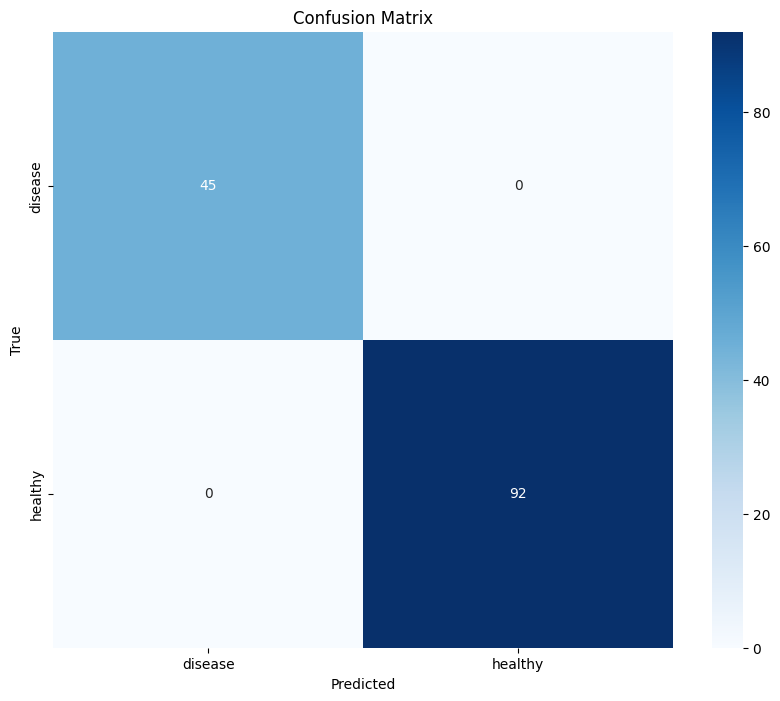

In [ ]:
classes = ["disease","healthy"]

import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# Confusion matrix 계산
cm = confusion_matrix(all_labels, all_predictions)

# 정확도, 정밀도, 재현율, F1 점수 계산
accuracy = accuracy_score(all_labels, all_predictions)
precision = precision_score(all_labels, all_predictions, average='weighted')
recall = recall_score(all_labels, all_predictions, average='weighted')
f1 = f1_score(all_labels, all_predictions, average='weighted')

# 시각화
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')

# 출력
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

plt.show()

In [ ]:
len(misclassified_images)

0

In [ ]:
# Assuming you have defined the 'classes' list and 'misclassified_images' list before this code snippet

# Set the number of rows and columns for the grid
num_rows = 3
num_columns = 5

for class_index in range(len(classes)):
    # Get misclassified images for the current class
    misclassified_images_class = [(image, predicted_label, true_label) for image, predicted_label, true_label in misclassified_images if true_label == class_index]

    if not misclassified_images_class:
        continue

    # Print class name
    print(f"\nClass {classes[class_index]}:")

    # Display misclassified images for the current class
    num_images = min(num_rows * num_columns, len(misclassified_images_class))
    fig, axes = plt.subplots(num_rows, num_columns, figsize=(15, 8))

    for i in range(num_rows):
        for j in range(num_columns):
            index = i * num_columns + j
            if index < num_images:
                # Reshape the image tensor and convert it to a NumPy array
                image = misclassified_images_class[index][0].permute(1, 2, 0).cpu().numpy()

                # Display the image with adjusted size
                axes[i, j].imshow(image)
                axes[i, j].set_title(f"Pred: {classes[misclassified_images_class[index][1] % len(classes)]}, True: {classes[misclassified_images_class[index][2]]}")
                axes[i, j].axis('off')

    plt.tight_layout()
    plt.show()

In [ ]:
! git clone https://github.com/FrancescoSaverioZuppichini/A-journey-into-Convolutional-Neural-Network-visualization-.git

Cloning into 'A-journey-into-Convolutional-Neural-Network-visualization-'...
remote: Enumerating objects: 238, done.
remote: Total 238 (delta 0), reused 0 (delta 0), pack-reused 238
Receiving objects: 100% (238/238), 106.41 MiB | 20.54 MiB/s, done.
Resolving deltas: 100% (70/70), done.


In [ ]:
%cd A-journey-into-Convolutional-Neural-Network-visualization-/

/content/A-journey-into-Convolutional-Neural-Network-visualization-


In [ ]:
from torchvision.models import *
from visualisation.core.utils import device
from efficientnet_pytorch import EfficientNet
import glob
import matplotlib.pyplot as plt
import numpy as np
import torch
from utils import *
import PIL.Image
import cv2

from visualisation.core.utils import device
from visualisation.core.utils import image_net_postprocessing

from torchvision.transforms import ToTensor, Resize, Compose, ToPILImage
from visualisation.core import *
from visualisation.core.utils import image_net_preprocessing

# for animation
%matplotlib inline
from IPython.display import Image
from matplotlib.animation import FuncAnimation
from collections import OrderedDict

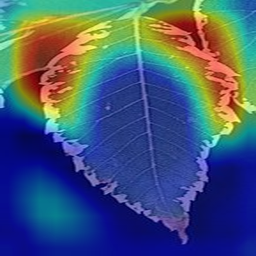

In [13]:
from PIL import Image

image_paths = [
"/content/drive/MyDrive/느티나무/test/disease/flickr_180_1.jpg"
]

# Load the images
images = [Image.open(path).convert('RGB') for path in image_paths]
inputs  = [Compose([Resize((224,224)), ToTensor(), image_net_preprocessing])(x).unsqueeze(0) for x in images]
inputs = [i.to(device) for i in inputs]

model_outs = OrderedDict()
model_name = 'efficientnet_b7'

model.eval()

# Assuming GradCam is defined appropriately
vis = GradCam(model, device)

model_outs[model_name] = list(map(lambda x: tensor2img(vis(x, None, postprocessing=image_net_postprocessing)[0]), inputs))

del model
torch.cuda.empty_cache()